# Probability distribution as a function of time

For a set of times, shows the probabilities for the true class and a handful of confusing classes as a function of time, for one classifier and one true class.

Supposed to be a whole bunch of violin plots.  Right now, it's not very pretty, but the basic idea is plotted.

In [1]:
%matplotlib inline
import sys
import os
import logging
import numpy
import pandas
import matplotlib
from matplotlib import pyplot
import seaborn
import sklearn
import sklearn.metrics

from metric_querier import ELAsTiCCMetricsQuerier

In [2]:
logger = logging.getLogger(__name__)
if not logger.hasHandlers():
    _logout = logging.StreamHandler( sys.stderr )
    logger.addHandler( _logout )
    _formatter = logging.Formatter( f'[%(asctime)s - %(levelname)s] - %(message)s', datefmt='%Y-%m-%d %H:%M:%S' )
    _logout.setFormatter( _formatter )

logger.setLevel( logging.DEBUG )

In [3]:
username = "rknop"
with open( os.path.join( os.getenv("HOME"), "secrets", "tom_"+username+"_passwd" ) ) as ifp:
    password = ifp.readline().strip()
    
emq = ELAsTiCCMetricsQuerier( tomusername=username, tompasswd=password, logger=logger )

In [4]:
# Run help(ELAsTiCCMetricsQuerier) for lots of information
probhist = emq.probhist()

[2023-03-13 10:49:03 - DEBUG] - Sending query to get probabilistic metrics histogram table
[2023-03-13 10:49:16 - DEBUG] - Got response, pandifying
[2023-03-13 10:49:18 - DEBUG] - Done


In [29]:
# This one is important
# For each true class, a list of "confusion classes" to plot alongside it.
# The right thing to do is hard... you have to know what's in the data already!

confusionclasses = {
    # Ia -> Ia, Ibc, II, PISN, SLSN, TDE
    111: [ 111, 112, 113, 135, 131, 132 ],
}

confusioncolors = [ 'green', 'red', 'blue', 'orange', 'darkviolet', 'darkturquoise' ]

In [41]:
# cferstodo = list( emq.classifier_info.keys() )
cferstodo = [ 40, 89, 44 ]
# cferstodo = [ 40 ]
# trueclasstodo = [ 111, 112, 113, 131 ]
trueclasstodo = [ 111 ]

# Every time bin is overwhelming.  Choose some time bins to do
# Let's do -10 days, 0 days, 30 days, 60 days, and >=100 days
tbinstodo = [ 5, 7, 13, 19, 27 ]

print( f"Going to do classifiers: {cferstodo}" )
print( f"Going to do classes: {[emq.classname[i] for i in trueclasstodo]}" )

Going to do classifiers: [40, 89, 44]
Going to do classes: ['Ia']


[2023-03-13 12:27:42 - DEBUG] - doing cfer 40, true class Ia
[2023-03-13 12:27:42 - DEBUG] - doing cfer 89, true class Ia
[2023-03-13 12:27:43 - DEBUG] - doing cfer 44, true class Ia


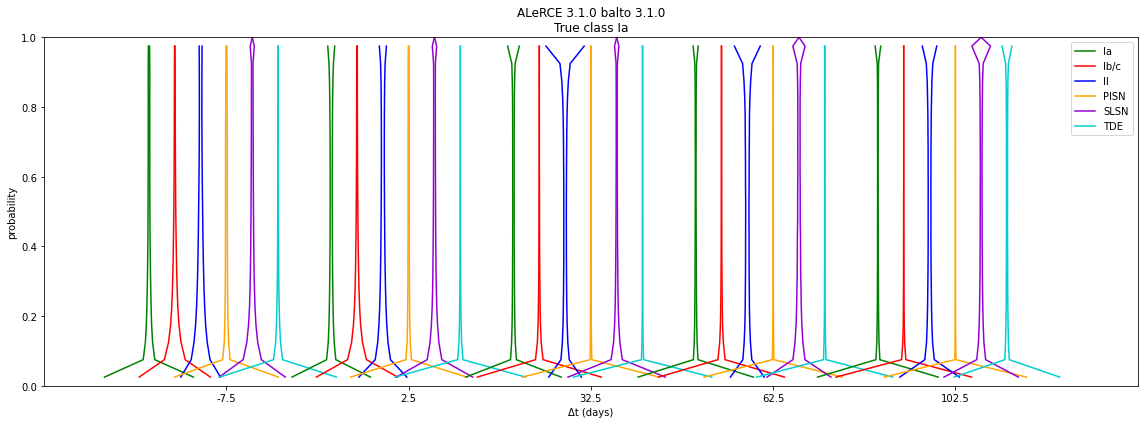

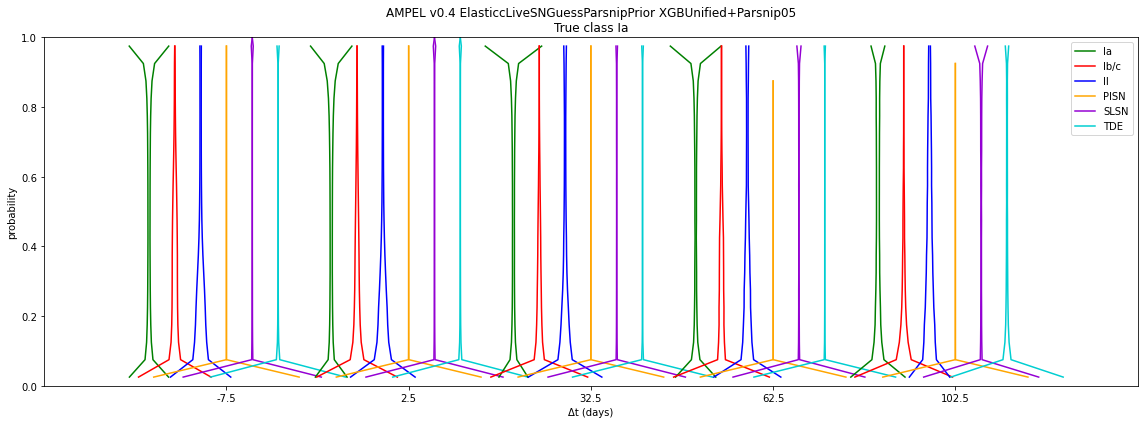

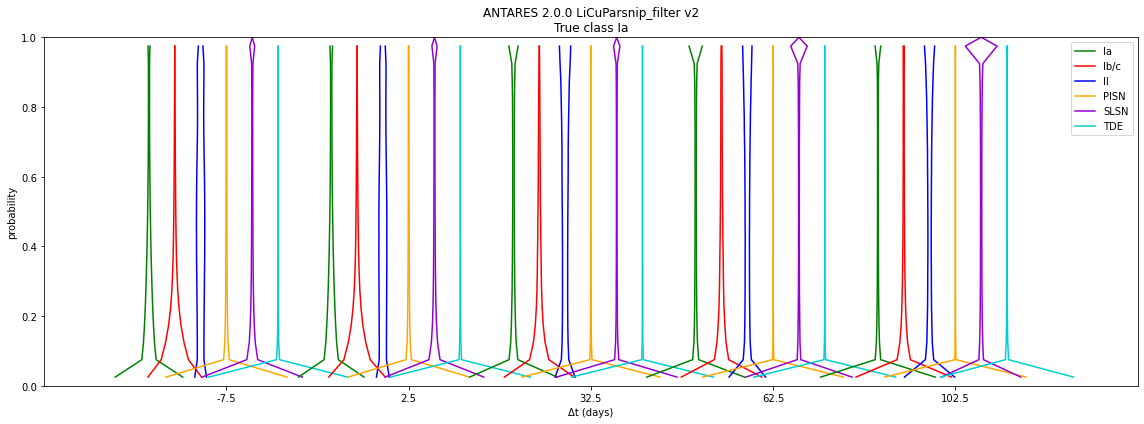

In [42]:
for cfer in cferstodo:
    brokername = emq.classifier_info[cfer]['brokerName']
    brokerversion = emq.classifier_info[cfer]['brokerVersion']
    classifiername = emq.classifier_info[cfer]['classifierName']
    classifierparams = emq.classifier_info[cfer]['classifierParams']
    cfertitle = f'{brokername} {brokerversion} {classifiername} {classifierparams}'
    for trueclass in trueclasstodo:
        logger.debug( f"doing cfer {cfer}, true class {emq.classname[trueclass]}" )
        subdf = probhist.xs( ( cfer, trueclass ), level=( 'classifierId', 'trueClassId' ) )
        probdf = subdf / subdf.groupby( ['classId', 'tbin'] ).sum()
        probdf.reset_index( inplace=True )
        probdf.set_index( ['tbin', 'probbin', 'classId'], inplace=True )
        # Extract just the t bins to do
        probdf = probdf.loc[ pandas.IndexSlice[ tbinstodo, :, : ] ]
        # Calculate probabilities
        probdf.reset_index( inplace=True )
        probdf['prob'] = emq.probbin_val( probdf['probbin'] )
        probdf.set_index( [ 'tbin', 'classId' ], inplace=True )
        
        fig = pyplot.figure( figsize=(16, 6), tight_layout=True )
        ax = fig.add_subplot( 1, 1, 1 )
        ax.set_title( f"{cfertitle}\nTrue class {emq.classname[trueclass]}" )
        
        tdex = numpy.arange( len(tbinstodo) )
        ax.set_xlim( tdex[0] - 1 , tdex[-1] + 1 )
        ax.set_ylim( 0., 1.)
        ax.set_xticks( tdex )
        ax.set_xticklabels( [ emq.tbin_val(i) for i in tbinstodo ] )
        ax.set_xlabel( 'Δt (days)' )
        ax.set_ylabel( 'probability' )
        
        # I'm doing violin plots "manually" here since the actual violin plot methods
        # assume you're feeding it raw data, but what we have is binned data.
        
        for ti in tdex:
            for confdex in range(len(confusionclasses[trueclass])):
                confoff = 0.85 * ( confdex - len(confusionclasses[trueclass])/2. ) / len(confusionclasses[trueclass])
                thist = probdf.xs( ( tbinstodo[ti], confusionclasses[trueclass][confdex] ), level=( 'tbin', 'classId' ) )
                # display(thist)
                yvals = thist['prob']
                xvals = ti + thist['count']
                
                if ( ti == 0 ) :
                    ax.plot( confoff + ti + 0.4*thist['count'], thist['prob'], color=confusioncolors[confdex],
                             label=emq.classname[ confusionclasses[trueclass][confdex] ] )
                else:
                    ax.plot( confoff + ti + 0.4*thist['count'], thist['prob'], color=confusioncolors[confdex] )
                ax.plot( confoff + ti - 0.4*thist['count'], thist['prob'], color=confusioncolors[confdex] )
            
        ax.legend()
        fig.show()
            
        